In [2]:
import pickle

import seaborn
import numpy as np
import pandas as pd
import torch
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import BinaryAccuracy

from project.pipeline.balance_data import balance_data_indices_reduction
from project.pipeline.data_loader import DataLoader

In [4]:
with open('../cached/toxic_bert_results.pickle', 'rb') as handle:
    toxic_bert_results = pickle.load(handle)

In [5]:
df_results = pd.DataFrame(toxic_bert_results)
df_results.head()

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
0,0.671682,0.006681,0.603532,0.000814,0.016570,0.000918
1,0.913387,0.026864,0.206393,0.006488,0.428129,0.611231
2,0.998545,0.451745,0.993932,0.006212,0.917578,0.058288
3,0.012694,0.000109,0.000558,0.000169,0.000580,0.000266
4,0.905675,0.033990,0.168355,0.059374,0.110174,0.495062


In [6]:
def sexist_heuristic(row):
    values = list(row.values)
    values = np.array(values)
    sexist = np.any(values >= 0.5)
    return sexist

In [7]:
df_results['sexist'] = df_results.apply(sexist_heuristic, axis=1)
df_results.head()

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexist
0,0.671682,0.006681,0.603532,0.000814,0.016570,0.000918,True
1,0.913387,0.026864,0.206393,0.006488,0.428129,0.611231,True
2,0.998545,0.451745,0.993932,0.006212,0.917578,0.058288,True
3,0.012694,0.000109,0.000558,0.000169,0.000580,0.000266,False
4,0.905675,0.033990,0.168355,0.059374,0.110174,0.495062,True


In [8]:
df_data = DataLoader().df
df_data.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [9]:
balanced_df_indices = balance_data_indices_reduction(df_data['label_sexist'])

In [10]:
target = df_data['label_sexist']
target = torch.tensor(np.array([entry != "not sexist" for entry in target]))
predictions = torch.tensor(np.array(df_results['sexist']))

In [19]:
accuracy_metric = BinaryAccuracy()
confusion_matrix_metric = ConfusionMatrix(num_classes=2)
labels = ["not sexist", "sexist"]

Accuracy on whole dataset: 0.6120714545249939


<AxesSubplot: >

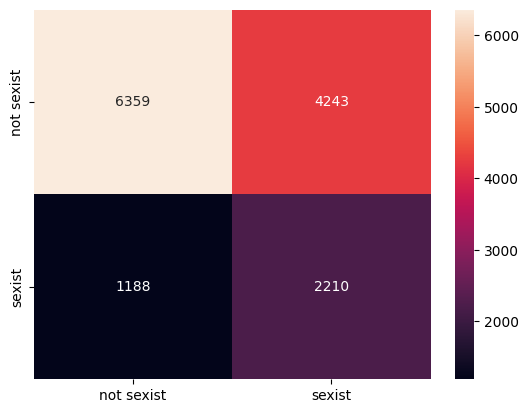

In [20]:
acc = accuracy_metric(predictions, target)
mat = confusion_matrix_metric(predictions, target)
print(f"Accuracy on whole dataset: {acc}")
seaborn.heatmap(mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)

Accuracy on balanced dataset: 0.6265450119972229


<AxesSubplot: >

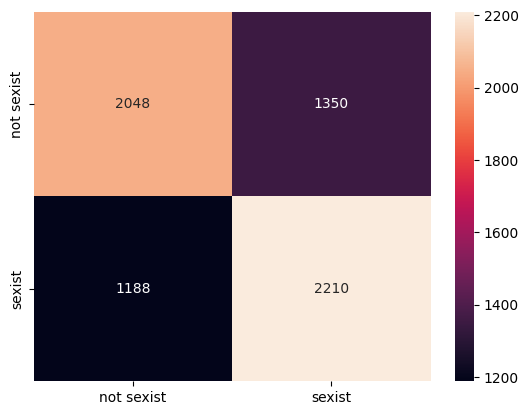

In [22]:
acc = accuracy_metric(predictions[balanced_df_indices], target[balanced_df_indices])
mat = confusion_matrix_metric(predictions[balanced_df_indices], target[balanced_df_indices])
print(f"Accuracy on balanced dataset: {acc}")
seaborn.heatmap(mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)